# Importing the Libraries

In [ ]:
import numpy as np
import tensorflow as tf 
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.applications.resnet50 import ResNet50
from keras.layers import Flatten, Dense, Dropout, UpSampling2D
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Convolution2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras.models import Sequential
from keras.initializers import RandomNormal
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import Callback,ModelCheckpoint
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import random as rand
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

# Skewing the Data

In [ ]:
def get_data(skew_ratio, num_of_class):
  
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  y_train.reshape((50000))
  y_test.reshape((10000))
  # integers = rand.randint(1,3)
  integers = num_of_class
  skew_amount = int(5000/skew_ratio)
  class_index = []
  class_index = np.random.choice(10, integers, replace = False)

  for j in class_index:
    indices = np.where(y_train == j)[0]
    np.random.shuffle(indices)
    delete_indices = indices[skew_amount:]
    y_train = np.delete(y_train, list(delete_indices))
    x_train = np.delete(x_train, list(delete_indices), axis = 0)

  return x_train, y_train, x_test, y_test, class_index
  

# Loading the data and Preprocessing

In [ ]:
# ONLY WHEN REQUIRED
# path = "/content/drive/My Drive/CIFAR10/Imbalance/Class_Fraction_Constant/3/5/Imbalance/Data"
x_train, y_train, x_test, y_test, class_index  = get_data(5, 3)

np.savez(path + "/data.npz",name1 = x_train, name2 = y_train, name3 = x_test, name4 = y_test)
num_classes = 10

y_test_1 =  y_test
y_train_1 = y_train

In [ ]:
# ONLY WHEN REQUIRED
path = "/content/drive/My Drive/CIFAR10/Imbalance/Class_Fraction_Constant/3/5/Imbalance/Data"
c = np.load(path + "/data.npz")
x_train = c["name1"]
y_train =  c["name2"]
x_test =  c["name3"]
y_test =  c["name4"]

y_test_1 =  y_test
y_train_1 = y_train

# Over Sampling the Data

In [ ]:
class_index = [2,6,8]
import numpy as np

#Over Sampling
over_sampled_label = []
over_sampled_images = []
#over_sampled_x = np.zeros((4000,32,32,3))
over_sampled_images = []


for i in class_index:

  indices = np.where(y_train == i)[0]
  x_train_unsampled = np.take(x_train, indices, axis = 0)
  for j in range(int(5000/len(indices))- 1):
    over_sampled_images.extend(x_train_unsampled)

  over_sampled_y = [i]*(5000 - len(indices))
  over_sampled_label.extend(over_sampled_y)

over_sampled_y = np.array(over_sampled_label)
over_sampled_x = np.array(over_sampled_images)


# #Ramdam Augmentation
oversampling = ImageDataGenerator(width_shift_range=[-3,3], height_shift_range=[-3,3], horizontal_flip = True, zoom_range = 0.2)
oversampling.fit(over_sampled_x)
oversampled_data_generator = oversampling.flow(over_sampled_x, over_sampled_y, batch_size =len(over_sampled_y))
over_sampled_data = next(iter(oversampled_data_generator))
x_train_oversample = over_sampled_data[0]
y_train_oversample = over_sampled_data[1]


# # Merging the data back
x_train = np.concatenate((x_train, x_train_oversample))
y_train = np.concatenate((y_train, y_train_oversample))


In [ ]:
print(x_train_oversample.shape)

(12000, 32, 32, 3)


6


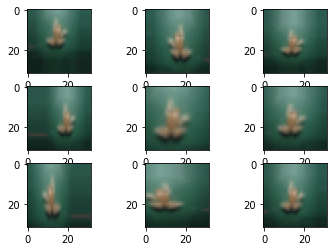

In [ ]:
i = 10089
data = x_train_oversample[i]
print(y_train_oversample[i])
# expand dimension to one sample
samples = np.expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=[-3,3], height_shift_range=[-3,3], horizontal_flip = True, zoom_range = 0.4)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# Show the figure
plt.show()

In [ ]:

num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
train_loader = ImageDataGenerator(samplewise_center = True, samplewise_std_normalization = True, zca_whitening = False)
test_loader = ImageDataGenerator(samplewise_center = True, samplewise_std_normalization = True, zca_whitening = False)

train_loader.fit(x_train)
test_loader.fit(x_test)

data_generator_train =train_loader.flow(x_train, y_train, 
                                        batch_size= 64, 
                                        shuffle = True)

data_generator_test =test_loader.flow(x_test, y_test, 
                                        batch_size= 64,
                                       shuffle = False)

# Visualize the distribution

<BarContainer object of 10 artists>

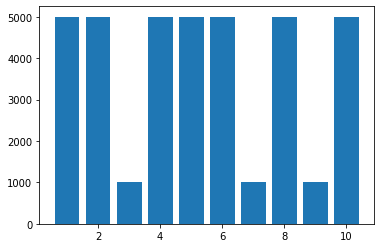

In [ ]:
y_train_1 = y_train_1.reshape((len(y_train_1)))
plt.bar(np.arange(1,11), height = np.bincount(y_train_1))

In [ ]:
y_train = y_train.reshape((len(y_train)))
plt.bar(np.arange(1,11), height = np.bincount(y_train))

In [ ]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

import keras
from keras import backend as K
import tensorflow as tf

# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

def categorical_focal_loss(gamma=2., alpha=.25):

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(loss, axis=1)

    return categorical_focal_loss_fixed

classifier = Sequential()
random_uniform = RandomNormal(mean=0.0, stddev=0.01, seed=None)

classifier.add(Dropout(0.25,input_shape = (32,32,3)))

classifier.add(Convolution2D(96,(3,3), padding = 'same', strides = 1,kernel_initializer =random_uniform, bias_initializer = "zeros" ))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Convolution2D(96,(3,3), padding = 'same', strides = 1,kernel_initializer =random_uniform))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Convolution2D(96,(3,3), padding = 'same', strides = 2,kernel_initializer =random_uniform, bias_initializer = "zeros"))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Dropout(0.50))

classifier.add(Convolution2D(192,(3,3), padding = 'same', strides = 1,kernel_initializer =random_uniform, bias_initializer = "zeros"))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Convolution2D(192,(3,3), padding = 'same', strides = 1,kernel_initializer =random_uniform, bias_initializer = "zeros"))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Convolution2D(192,(3,3), padding = 'same', strides = 2,kernel_initializer =random_uniform, bias_initializer = "zeros"))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Dropout(0.50))

classifier.add(Convolution2D(192,(3,3), padding = 'same', strides = 1,kernel_initializer =random_uniform, bias_initializer = "zeros"))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Dropout(0.50))

classifier.add(Convolution2D(192,(1,1), padding = 'same', strides = 1,kernel_initializer =random_uniform, bias_initializer = "zeros"))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Convolution2D(10,(1,1), padding = 'same', strides = 1,kernel_initializer =random_uniform, bias_initializer = "zeros"))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(GlobalAveragePooling2D())
classifier.add(Activation("softmax"))

checkpoint = ModelCheckpoint('/content/drive/My Drive/CIFAR10/Imbalance/Class_Fraction_Constant/3/5/Model/model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

adam = optimizers.Adam(lr=0.0001, decay=1e-4)
classifier.compile(optimizer = adam , loss=[focal_loss], metrics = [get_f1] )

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_1),
                                                 y_train_1)

# Training the model

In [ ]:
batch_size = 64
history = classifier.fit_generator(data_generator_train,     
                         steps_per_epoch = len(y_train)/(batch_size),
                        validation_data = data_generator_test, 
                        validation_steps = len(y_test)/(batch_size),
                      epochs = 30,
                      shuffle = True)

# classifier.save("/content/drive/My Drive/CIFAR10/Imbalance/Class_Fraction_Constant/3/5/Oversample_Augment/model_100_2epochs.h5")

# Plotting the accuracy and loss

# Plot training & validation accuracy values
plt.plot(history.history['get_f1'])
plt.plot(history.history['val_get_f1'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Epoch 1/30
782/781 [==============================] - 32s 40ms/step - loss: 21.1865 - get_f1: 0.0450 - val_loss: 5.7622 - val_get_f1: 0.2144
Epoch 2/30
782/781 [==============================] - 30s 38ms/step - loss: 16.9326 - get_f1: 0.1600 - val_loss: 5.6870 - val_get_f1: 0.2366
Epoch 3/30
782/781 [==============================] - 30s 38ms/step - loss: 15.2587 - get_f1: 0.2396 - val_loss: 4.6709 - val_get_f1: 0.3166
Epoch 4/30
782/781 [==============================] - 30s 38ms/step - loss: 14.0652 - get_f1: 0.3005 - val_loss: 2.6753 - val_get_f1: 0.3868
Epoch 5/30
782/781 [==============================] - 30s 38ms/step - loss: 13.1025 - get_f1: 0.3504 - val_loss: 4.9526 - val_get_f1: 0.3753
Epoch 6/30
782/781 [==============================] - 30s 38ms/step - loss: 12.3778 - get_f1: 0.3896 - val_loss: 3.0495 - val_get_f1: 0.3961
Epoch 7/30
782/781 [==============================] - 30s 38ms/step - loss: 11.7497 - get_f1: 0.4255 - val_loss: 3.8773 - val_get_f1: 0.4326
Epoch 8/30
78

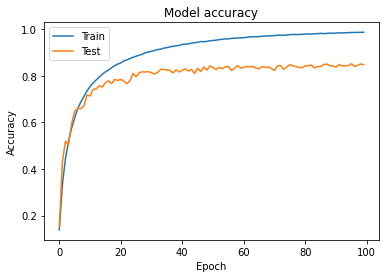

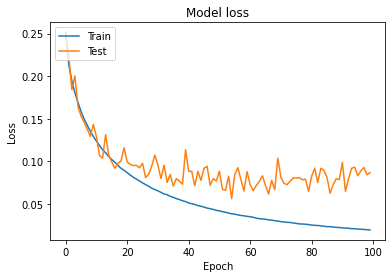

In [ ]:
# Plotting the accuracy and loss

# Plot training & validation accuracy values
plt.plot(history.history['get_f1'])
plt.plot(history.history['val_get_f1'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
classifier.save("/content/drive/My Drive/CIFAR10/Imbalance/Class_Fraction_Constant/3/5/Focal Loss/Model/model_100_epochs.h5")

# Confusion matrix

157/156 [==============================] - 2s 12ms/step


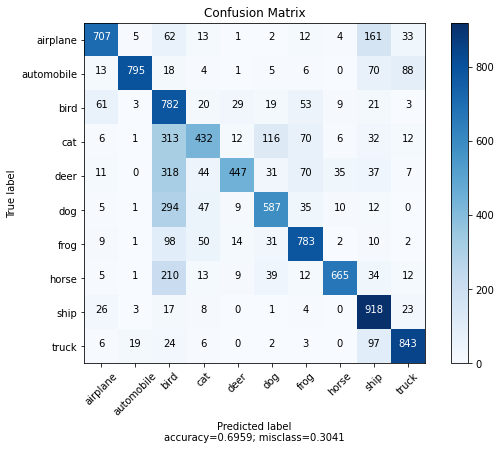

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


Y_pred = classifier.predict_generator(data_generator_test , 10000/64, verbose =1)
y_pred = np.argmax(Y_pred, axis=1)


plot_confusion_matrix(cm          = confusion_matrix(y_test_1, y_pred), 
                      normalize    = False,
                      target_names = ['airplane', 'automobile', 'bird', 'cat','deer', "dog", "frog", "horse", "ship", "truck"],
                      title        = "Confusion Matrix")

# Plotting ROC_AUC Curve

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


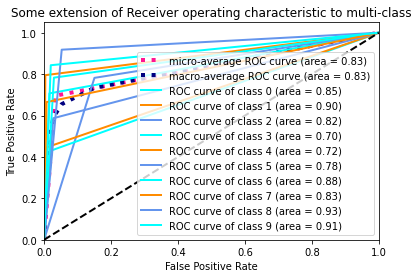

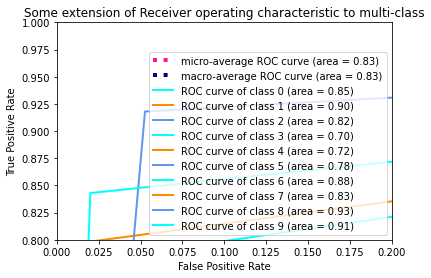

In [ ]:
from sklearn.preprocessing import label_binarize

y_score = label_binarize(y_pred, classes=[0,1,2,3,4,5,6,7,8,9])
y_test = label_binarize(y_test, classes = [0,1,2,3,4,5,6,7,8,9])
n_classes = 10

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()